<a href="https://www.kaggle.com/code/farukgrrolu/finding-talent-footballer-via-ml?scriptVersionId=115187008" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Finding New Talents For Football Industry

**Predicting talent players in which class (average, highlighted) according to the scores given to the characteristics of the football players followed by the Scouts. We have two datasets for this case. And we will analyse and combine them as in following steps:**

# 1. Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_validate
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score
pd.set_option('display.width', 600) 
import warnings 
warnings.simplefilter(action='ignore', category=Warning)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/scoutiumattributes/scoutium_attributes.csv
/kaggle/input/scoutiumpotentiallabels/scoutium_potential_labels.csv


In [3]:
sc_attrs = pd.read_csv("/kaggle/input/scoutiumattributes/scoutium_attributes.csv", sep=";")
sc_labels = pd.read_csv("/kaggle/input/scoutiumpotentiallabels/scoutium_potential_labels.csv", sep=";")

# 2. Analysis the Datasets

**Let's write the function which will help us for checking both datasets:**

In [4]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

**"Attributes" dataset check:**

In [5]:
check_df(sc_attrs)

##################### Shape #####################
(10730, 8)
##################### Types #####################
task_response_id      int64
match_id              int64
evaluator_id          int64
player_id             int64
position_id           int64
analysis_id           int64
attribute_id          int64
attribute_value     float64
dtype: object
##################### Head #####################
   task_response_id  match_id  evaluator_id  player_id  position_id  analysis_id  attribute_id  attribute_value
0              4915     62935        177676    1361061            2     12818495          4322             56.0
1              4915     62935        177676    1361061            2     12818495          4323             56.0
2              4915     62935        177676    1361061            2     12818495          4324             67.0
3              4915     62935        177676    1361061            2     12818495          4325             56.0
4              4915     62935        17767

"Labels" dataset check:

In [6]:
check_df(sc_labels)

##################### Shape #####################
(322, 5)
##################### Types #####################
task_response_id     int64
match_id             int64
evaluator_id         int64
player_id            int64
potential_label     object
dtype: object
##################### Head #####################
   task_response_id  match_id  evaluator_id  player_id potential_label
0              4915     62935        177676    1361061         average
1              4915     62935        177676    1361626     highlighted
2              4915     62935        177676    1361858         average
3              4915     62935        177676    1362220     highlighted
4              4915     62935        177676    1364951     highlighted
##################### Tail #####################
     task_response_id  match_id  evaluator_id  player_id potential_label
317              5642     63032        151191    1367783     highlighted
318              5642     63032        151191    1369525         average

**Now, we'll combine these two datasets thanks to using "merge" commandfor common features as ("task_response_id", 'match_id', 'evaluator_id' "player_id").**

In [7]:
df = scoutium = pd.merge(sc_attrs, sc_labels, on=["task_response_id", "match_id", "evaluator_id", "player_id"])

**Checking dataset which we combined it as one data using "check_df" function:**

In [8]:
check_df(df)

##################### Shape #####################
(10730, 9)
##################### Types #####################
task_response_id      int64
match_id              int64
evaluator_id          int64
player_id             int64
position_id           int64
analysis_id           int64
attribute_id          int64
attribute_value     float64
potential_label      object
dtype: object
##################### Head #####################
   task_response_id  match_id  evaluator_id  player_id  position_id  analysis_id  attribute_id  attribute_value potential_label
0              4915     62935        177676    1361061            2     12818495          4322             56.0         average
1              4915     62935        177676    1361061            2     12818495          4323             56.0         average
2              4915     62935        177676    1361061            2     12818495          4324             67.0         average
3              4915     62935        177676    1361061        

# 3. Dropping Goalkeeper(1) Class from "position_id" Feature

In [9]:
df.drop(df.loc[df["position_id"]==1].index, inplace=True)

**Checking if we still have position_id (1) in dataset or not!:**

In [10]:
df.loc[df["position_id"]==1].head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value,potential_label


# 4. Removing The "below-average" class in the Potential Label

**We're doing this because the below average class makes up 1% of the entire dataset. We'll use drop command for this task.**

In [11]:
df.drop(df.loc[df["potential_label"]=="below_average"].index, inplace=True)

In [12]:
df.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value,potential_label
0,4915,62935,177676,1361061,2,12818495,4322,56.0,average
1,4915,62935,177676,1361061,2,12818495,4323,56.0,average
2,4915,62935,177676,1361061,2,12818495,4324,67.0,average
3,4915,62935,177676,1361061,2,12818495,4325,56.0,average
4,4915,62935,177676,1361061,2,12818495,4326,45.0,average


# 5. New Table via Using Pivot Table Function**

**Indexes will be formed : “player_id”,“position_id” and “potential_label”.
Columns will be formed : “attribute_id”
Values: “attribute_value”**

In [13]:
pd.pivot_table(df, 
               values=["attribute_value"], 
               index=["player_id","position_id","potential_label"],
               columns=["attribute_id"],
               aggfunc={"attribute_value":np.mean})

attribute_value                                                        ...                                                            
attribute_id                                     4322  4323  4324  4325  4326  4327  4328  4329  4330  4332  ...  4352  4353  4354  4355  4356  4357  4407  4408  4423  4426
player_id position_id potential_label                                                                        ...                                                            
1355710   7           average                    50.5  50.5  34.0  50.5  45.0  45.0  45.0  45.0  50.5  56.0  ...  56.0  34.0  39.5  50.5  34.0  34.0  56.0  34.0  34.0  56.0
1356362   9           average                    67.0  67.0  67.0  67.0  67.0  67.0  67.0  67.0  67.0  67.0  ...  67.0  67.0  78.0  67.0  67.0  67.0  67.0  67.0  56.0  78.0
1356375   3           average                    67.0  67.0  67.0  67.0  67.0  67.0  67.0  78.0  67.0  67.0  ...  67.0  67.0  78.0  67.0  67.0  67.0  67.0  67.0  56.0  78.0
          4           average                    67.0  78.0  67.0  67.0  67.0  78.0  78.0  78.0  56.0  67.0  ...  78.0  67.0  67.0  67.0  56.0  67.0  56.0  67.0  45.0  56.0
1356411   9           average                    67.0  67.0  78.0  78.0  67.0  67.0  67.0  67.0  89.0  78.0  ...  67.0  56.0  67.0  67.0  56.0  67.0  89.0  56.0  67.0  78.0
...                                               ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...
1907347   5           average                    67.0  78.0  78.0  56.0  78.0  67.0  78.0  67.0  56.0  78.0  ...  67.0  67.0  67.0  67.0  56.0  67.0  78.0  78.0  78.0  56.0
          6           average                    67.0  67.0  67.0  67.0  67.0  67.0  67.0  78.0  67.0  67.0  ...  67.0  67.0  78.0  67.0  67.0  67.0  67.0  67.0  67.0  78.0
1909532   10          average                    56.0  45.0  45.0  45.0  56.0  56.0  56.0  56.0  23.0  23.0  ...  45.0  45.0  56.0  34.0  34.0  56.0  34.0  34.0  34.0  23.0
1909724   2           highlighted                78.0  78.0  78.0  78.0  78.0  78.0  78.0  78.0  67.0  67.0  ...  78.0  78.0  78.0  67.0  67.0  67.0  78.0  78.0  67.0  78.0
1909728   7           highlighted                78.0  67.0  67.0  78.0  67.0  67.0  67.0  78.0  67.0  67.0  ...  67.0  67.0  78.0  67.0  67.0  67.0  78.0  67.0  67.0  78.0

[271 rows x 34 columns]

In [14]:
df_pivot = pd.pivot_table(df, 
               values=["attribute_value"], 
               index=["player_id","position_id","potential_label"],
               columns=["attribute_id"],
               aggfunc={"attribute_value":np.mean})

In [15]:
df_pivot = df_pivot.reset_index()    

In [16]:
new_cols=[]
for col in df_pivot.columns:
    if col[0] !="attribute_value":
        new_cols.append(col[0])
    else:
        new_cols.append(str(col[1]))
for new_col in new_cols:
    print(type(new_col),new_col)

<class 'str'> player_id
<class 'str'> position_id
<class 'str'> potential_label
<class 'str'> 4322
<class 'str'> 4323
<class 'str'> 4324
<class 'str'> 4325
<class 'str'> 4326
<class 'str'> 4327
<class 'str'> 4328
<class 'str'> 4329
<class 'str'> 4330
<class 'str'> 4332
<class 'str'> 4333
<class 'str'> 4335
<class 'str'> 4338
<class 'str'> 4339
<class 'str'> 4340
<class 'str'> 4341
<class 'str'> 4342
<class 'str'> 4343
<class 'str'> 4344
<class 'str'> 4345
<class 'str'> 4348
<class 'str'> 4349
<class 'str'> 4350
<class 'str'> 4351
<class 'str'> 4352
<class 'str'> 4353
<class 'str'> 4354
<class 'str'> 4355
<class 'str'> 4356
<class 'str'> 4357
<class 'str'> 4407
<class 'str'> 4408
<class 'str'> 4423
<class 'str'> 4426


In [17]:
df_pivot.columns=new_cols
df_pivot

,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,...,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,average,50.5,50.5,34.0,50.5,45.0,45.0,45.0,...,56.0,34.0,39.5,50.5,34.0,34.0,56.0,34.0,34.0,56.0
1,1356362,9,average,67.0,67.0,67.0,67.0,67.0,67.0,67.0,...,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,56.0,78.0
2,1356375,3,average,67.0,67.0,67.0,67.0,67.0,67.0,67.0,...,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,56.0,78.0
3,1356375,4,average,67.0,78.0,67.0,67.0,67.0,78.0,78.0,...,78.0,67.0,67.0,67.0,56.0,67.0,56.0,67.0,45.0,56.0
4,1356411,9,average,67.0,67.0,78.0,78.0,67.0,67.0,67.0,...,67.0,56.0,67.0,67.0,56.0,67.0,89.0,56.0,67.0,78.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,1907347,5,average,67.0,78.0,78.0,56.0,78.0,67.0,78.0,...,67.0,67.0,67.0,67.0,56.0,67.0,78.0,78.0,78.0,56.0
267,1907347,6,average,67.0,67.0,67.0,67.0,67.0,67.0,67.0,...,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,67.0,78.0
268,1909532,10,average,56.0,45.0,45.0,45.0,56.0,56.0,56.0,...,45.0,45.0,56.0,34.0,34.0,56.0,34.0,34.0,34.0,23.0
269,1909724,2,highlighted,78.0,78.0,78.0,78.0,78.0,78.0,78.0,...,78.0,78.0,78.0,67.0,67.0,67.0,78.0,78.0,67.0,78.0


# 6. Converting the “potential_label” Categories (average, highlighted) Numerically Using the Label Encoder function.

In [18]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe
for col in ["potential_label"]:
    label_encoder(df_pivot,col)

In [19]:
df_pivot.head()

,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,...,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,0,50.5,50.5,34.0,50.5,45.0,45.0,45.0,...,56.0,34.0,39.5,50.5,34.0,34.0,56.0,34.0,34.0,56.0
1,1356362,9,0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,...,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,56.0,78.0
2,1356375,3,0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,...,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,56.0,78.0
3,1356375,4,0,67.0,78.0,67.0,67.0,67.0,78.0,78.0,...,78.0,67.0,67.0,67.0,56.0,67.0,56.0,67.0,45.0,56.0
4,1356411,9,0,67.0,67.0,78.0,78.0,67.0,67.0,67.0,...,67.0,56.0,67.0,67.0,56.0,67.0,89.0,56.0,67.0,78.0


# 7. Assigned Numerical Columns as "num_cols"**

In [20]:
df_pivot.dtypes

player_id            int64
position_id          int64
potential_label      int64
4322               float64
4323               float64
4324               float64
4325               float64
4326               float64
4327               float64
4328               float64
4329               float64
4330               float64
4332               float64
4333               float64
4335               float64
4338               float64
4339               float64
4340               float64
4341               float64
4342               float64
4343               float64
4344               float64
4345               float64
4348               float64
4349               float64
4350               float64
4351               float64
4352               float64
4353               float64
4354               float64
4355               float64
4356               float64
4357               float64
4407               float64
4408               float64
4423               float64
4426               float64
d

In [21]:
num_cols = [col for col in df_pivot.columns if col not in ["player_id", "position_id", "potential_label"]]

In [22]:
num_cols

['4322',
 '4323',
 '4324',
 '4325',
 '4326',
 '4327',
 '4328',
 '4329',
 '4330',
 '4332',
 '4333',
 '4335',
 '4338',
 '4339',
 '4340',
 '4341',
 '4342',
 '4343',
 '4344',
 '4345',
 '4348',
 '4349',
 '4350',
 '4351',
 '4352',
 '4353',
 '4354',
 '4355',
 '4356',
 '4357',
 '4407',
 '4408',
 '4423',
 '4426']

# 8. Using StandartScaler for "num_cols"**

In [23]:
scaler = StandardScaler()
scaler.fit(df_pivot[num_cols])

df_pivot[num_cols] = scaler.transform(df_pivot[num_cols])
df_pivot[num_cols].head()

,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,...,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,-0.542606,-0.559398,-1.404764,-0.437916,-0.766602,-0.794802,-0.907351,-0.791605,-0.446324,-0.122619,...,0.012848,-1.281899,-1.132245,-0.494569,-1.234869,-1.519578,-0.142650,-1.487256,-0.955381,-0.252741
1,0.595327,0.560776,0.678677,0.682837,0.722639,0.722929,0.601190,0.404075,0.727985,0.691171,...,0.786581,0.813645,1.052769,0.631718,0.914913,0.768231,0.529664,0.668713,0.403717,1.041611
2,0.595327,0.560776,0.678677,0.682837,0.722639,0.722929,0.601190,1.001915,0.727985,0.691171,...,0.786581,0.813645,1.052769,0.631718,0.914913,0.768231,0.529664,0.668713,0.403717,1.041611
3,0.595327,1.307560,0.678677,0.682837,0.722639,1.481795,1.355461,1.001915,-0.054888,0.691171,...,1.560314,0.813645,0.428479,0.631718,0.198319,0.768231,-0.142650,0.668713,-0.275832,-0.252741
4,0.595327,0.560776,1.373158,1.430006,0.722639,0.722929,0.601190,0.404075,2.293730,1.504961,...,0.786581,0.115130,0.428479,0.631718,0.198319,0.768231,1.874292,-0.049944,1.083267,1.041611


**Time to checking "df_pivot" after scaler function**

In [24]:
check_df(df_pivot[num_cols])

##################### Shape #####################
(271, 34)
##################### Types #####################
4322    float64
4323    float64
4324    float64
4325    float64
4326    float64
4327    float64
4328    float64
4329    float64
4330    float64
4332    float64
4333    float64
4335    float64
4338    float64
4339    float64
4340    float64
4341    float64
4342    float64
4343    float64
4344    float64
4345    float64
4348    float64
4349    float64
4350    float64
4351    float64
4352    float64
4353    float64
4354    float64
4355    float64
4356    float64
4357    float64
4407    float64
4408    float64
4423    float64
4426    float64
dtype: object
##################### Head #####################
       4322      4323      4324      4325      4326      4327      4328      4329      4330      4332  ...      4352      4353      4354      4355      4356      4357      4407      4408      4423      4426
0 -0.542606 -0.559398 -1.404764 -0.437916 -0.766602 -0.794802 -0.907351 -0.7

# 9. Model Approachs**

In [25]:
X = df_pivot.drop(["potential_label", "player_id"], axis=1)
y = df_pivot["potential_label"]

**Splitting the dataset as test and train**

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Writing a function for seeing all ML models in one result**

In [27]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

def base_models(X, y, scoring):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                   ('LightGBM', LGBMClassifier()),
                   ('CatBoost', CatBoostClassifier(verbose=False))]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

scores = ["roc_auc", "f1", "precision", "recall", "accuracy"]

for i in scores:
    base_models(X, y, i)

Base Models....
roc_auc: 0.8177 (LR) 
roc_auc: 0.6914 (KNN) 
roc_auc: 0.8396 (SVC) 
roc_auc: 0.7451 (CART) 
roc_auc: 0.8968 (RF) 
roc_auc: 0.7781 (Adaboost) 
roc_auc: 0.8611 (GBM) 
roc_auc: 0.8441 (XGBoost) 
roc_auc: 0.8588 (LightGBM) 
roc_auc: 0.8924 (CatBoost) 
Base Models....
f1: 0.537 (LR) 
f1: 0.3457 (KNN) 
f1: 0.0351 (SVC) 
f1: 0.5247 (CART) 
f1: 0.5855 (RF) 
f1: 0.5668 (Adaboost) 
f1: 0.6031 (GBM) 
f1: 0.6037 (XGBoost) 
f1: 0.5788 (LightGBM) 
f1: 0.6066 (CatBoost) 
Base Models....
precision: 0.7331 (LR) 
precision: 0.9444 (KNN) 
precision: 0.3333 (SVC) 
precision: 0.5725 (CART) 
precision: 0.8586 (RF) 
precision: 0.6335 (Adaboost) 
precision: 0.7092 (GBM) 
precision: 0.6904 (XGBoost) 
precision: 0.6599 (LightGBM) 
precision: 0.8524 (CatBoost) 
Base Models....
recall: 0.4454 (LR) 
recall: 0.2154 (KNN) 
recall: 0.0185 (SVC) 
recall: 0.501 (CART) 
recall: 0.4103 (RF) 
recall: 0.5341 (Adaboost) 
recall: 0.5351 (GBM) 
recall: 0.5526 (XGBoost) 
recall: 0.5175 (LightGBM) 
recall: 0.480

# 10. Feature Impoortance Function

**We'll use feature function for indicate all importance features in each algorithm**

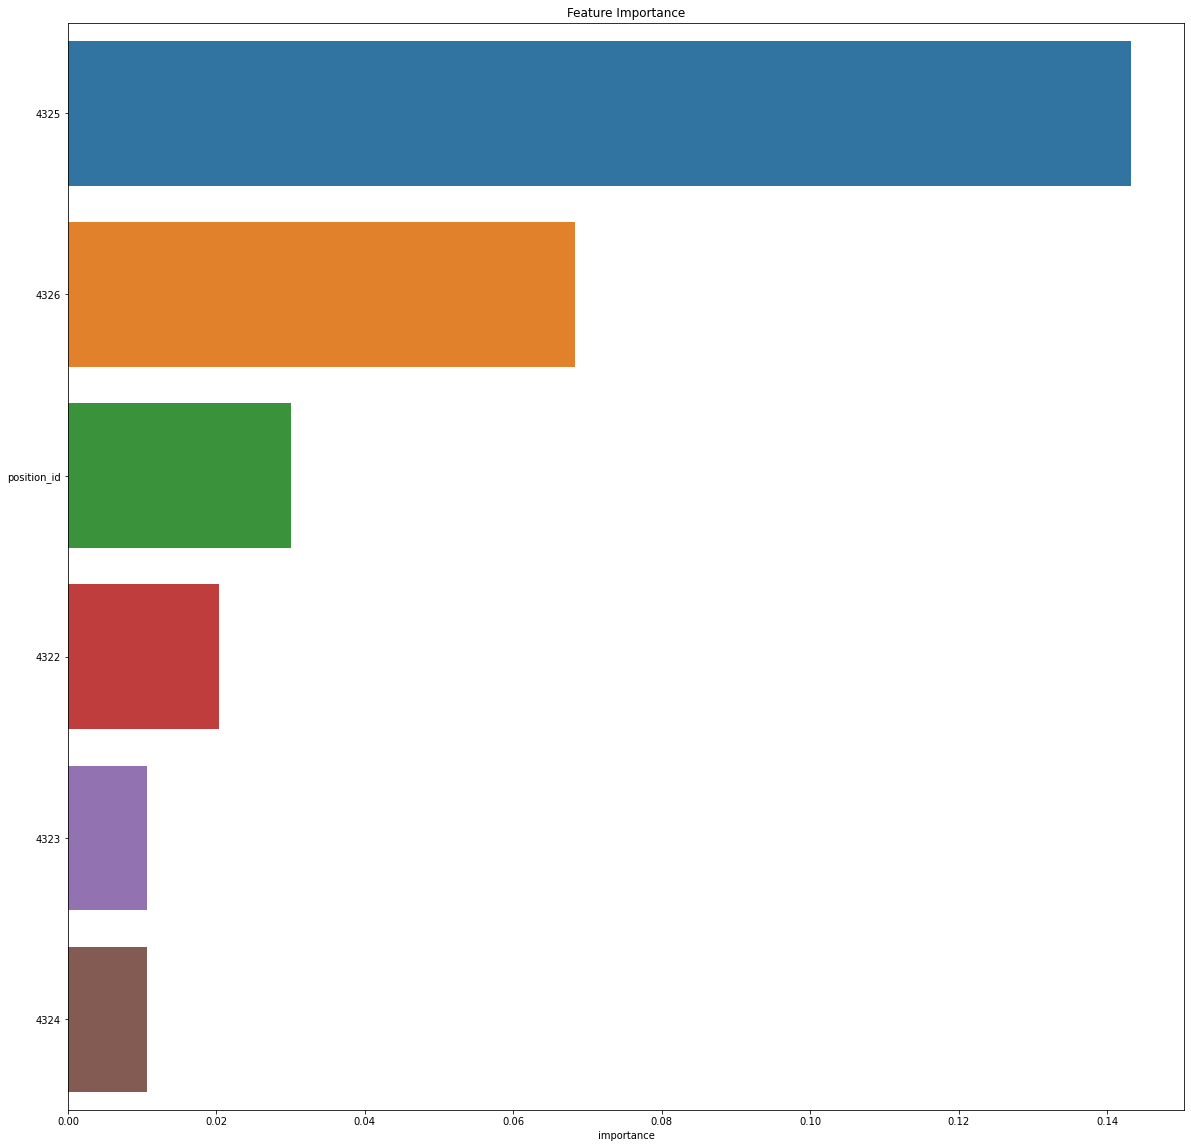

In [28]:
def feature_importance(model, X_train, y_train):
    model.fit(X_train, y_train)
    feature_importance = pd.DataFrame(model.feature_importances_, index=X_train.columns, columns=["importance"]).head(6)
    feature_importance.sort_values(by="importance", ascending=False, inplace=True)
    plt.figure(figsize=(20, 20))
    sns.barplot(x=feature_importance.importance, y=feature_importance.index)
    plt.title("Feature Importance")
    plt.show()

feature_importance(RandomForestClassifier(), X_train, y_train)